# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

When finished, you can close the environment.

env.close()

## Train your own agent

In [2]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import time
from maddpg_agent import Agent

In [6]:
# initialize agents
agent_0 = Agent(state_size, action_size, random_seed=0)
agent_1 = Agent(state_size, action_size, random_seed=0)
NO_NOISE = 300

In [7]:
def maddpg(n_episodes=2000, solve_score = 0.5):
    scores_deque = deque(maxlen=100)
    scores = []
    moving_average = []
    add_noise = True
    best_score = 0
    for i_episode in range(1, n_episodes+1):
        if i_episode > NO_NOISE:
            add_noise = False
        
        env_info = env.reset(train_mode=True)[brain_name]
        ## Concatenate the states of the 2 agents
        states = env_info.vector_observations
        score_all_agents = np.zeros(num_agents)
        agent_0.reset()
        agent_1.reset()
        
        time_episode_start = time.time()
        
        while True:
            
            # Concatenate actions of the 2 agents
            action_0 = agent_0.act(states[0], add_noise = add_noise)    # agent 0 chooses an action
            action_1 = agent_1.act(states[1], add_noise = add_noise)    # agent 1 chooses an action
            actions = np.concatenate((action_0, action_1), axis=0).flatten()
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards                        
            dones = env_info.local_done 
            ## Store Experience for each agent
            agent_0.step(states[0], action_0, rewards[0], next_states[0], dones[0]) # agent 1 learns
            agent_1.step(states[1], action_1, rewards[1], next_states[1], dones[1]) # agent 2 learns
            
            states = next_states
            score_all_agents += rewards ## Scores get updated based on max
            
            if np.any(dones):                                  
                break
        
        if np.max(score_all_agents) > best_score:
            best_score = np.max(score_all_agents)
        scores_deque.append(np.max(score_all_agents))
        scores.append(np.max(score_all_agents))
        moving_average.append(np.mean(scores_deque))
        
        if i_episode % 100 == 0:
            print('Episode {:3d} \tBest Score: {:5.2f} \t' \
                  'Moving average: {:5.2f}' \
                  .format(i_episode, best_score,
                          np.mean(scores_deque)))
        
#         print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), scores[-1]), end="")
        if i_episode % 100 == 0:
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')  
            
        if np.mean(scores_deque) >= solve_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_deque)))
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
    return scores, moving_average



In [8]:
train = True
if train:
    scores, moving_average = maddpg()

Episode 100 	Best Score:  0.00 	Moving average:  0.00
Episode 200 	Best Score:  0.10 	Moving average:  0.00
Episode 300 	Best Score:  0.10 	Moving average:  0.00
Episode 400 	Best Score:  0.20 	Moving average:  0.02
Episode 500 	Best Score:  0.20 	Moving average:  0.05
Episode 600 	Best Score:  0.20 	Moving average:  0.06
Episode 700 	Best Score:  0.30 	Moving average:  0.09
Episode 800 	Best Score:  0.50 	Moving average:  0.13
Episode 900 	Best Score:  0.50 	Moving average:  0.13
Episode 1000 	Best Score:  0.50 	Moving average:  0.15
Episode 1100 	Best Score:  1.00 	Moving average:  0.20
Episode 1200 	Best Score:  1.40 	Moving average:  0.27
Episode 1300 	Best Score:  2.20 	Moving average:  0.48

Environment solved in 1316 episodes!	Average Score: 0.51


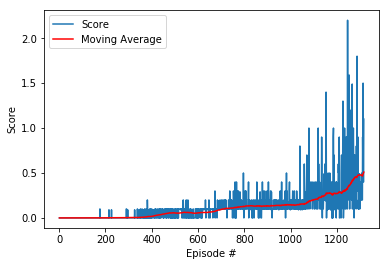

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label = 'Score')
plt.plot(np.arange(1, len(scores)+1), moving_average, color = 'r', label = 'Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

## Test this agent

In [3]:
## Load Envtt with Visualization
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [6]:
agent_0 = Agent(state_size, action_size, random_seed=0)
agent_1 = Agent(state_size, action_size, random_seed=0)
agent_0.actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth'))
agent_0.critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth'))
agent_1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent_1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

<All keys matched successfully>

In [10]:
scores = []
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores_all_agents = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        action_0 = agent_0.act(states[0], add_noise = False)    
        action_1 = agent_1.act(states[1], add_noise = False)
        actions = np.concatenate((action_0, action_1), axis=0).flatten()
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                        
        scores_all_agents += env_info.rewards                        
        states = next_states                              
        if np.any(dones):                                 
            break
    scores.append(np.max(scores_all_agents))
print("Scores are: ", scores)

Scores are:  [0.10000000149011612, 0.800000011920929, 1.2000000178813934, 0.10000000149011612, 0.4000000059604645]


In [11]:
env.close()